In [93]:
import sys
sys.path.append('..')
import os
from os.path import join
import numpy as np
import pandas as pd
import connattractor.network as network
import connattractor.analysis as analysis
from joblib import Parallel, delayed
import pickle
import matplotlib.pyplot as plt
from myst_nb import glue

import seaborn as sns
sns.set_style("whitegrid")

In [3]:
connfile = '../data_in/ex_connectome_partial_correlation.csv'
mtx = pd.read_csv(connfile).iloc[:, 1:]

hopnet = network.Hopfield(mtx.values, scale=True)

with open('../data_out/default_hopfield_embedding_0.37.pkl', 'rb') as file:
    hopfield_embedding = pickle.load(file)

# 1: explained variance of state energy by first two PCs

In [73]:
simresults_all = {}
hopfield_embeddings_all = {}

for noise in [0.31, 0.33, 0.35, 0.37, 0.39, 0.41]:
    simresults_all[noise] = analysis.simulate_activations(mtx.values, noise_coef=noise, 
                                                          num_iter=100000, beta=0.04, random_state=2023)
    hopfield_embeddings_all[noise] = analysis.create_embeddings(simresults_all[noise], 
                                                                attractor_sample=1000,random_state=2023)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.16it/s]


In [101]:
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVR

n_dim = 2 

model = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
expl_var = []
for noise, embedding in hopfield_embeddings_all.items():
    energy = np.array([embedding.hopnet.energy(s) for s in embedding.state_sample])
    embedded_states = embedding.embedding_model.transform(embedding.state_sample)
    y_pred = cross_val_predict(model, embedded_states[:,:n_dim], energy, cv=10)

    score = r2_score(energy, y_pred)
    expl_var.append(score)
    print(f'noise: {noise}, \t expl. var.: {np.round(score, decimals=3)}')

noise: 0.31, 	 expl. var.: 0.854
noise: 0.33, 	 expl. var.: 0.802
noise: 0.35, 	 expl. var.: 0.74
noise: 0.37, 	 expl. var.: 0.683
noise: 0.39, 	 expl. var.: 0.631
noise: 0.41, 	 expl. var.: 0.582


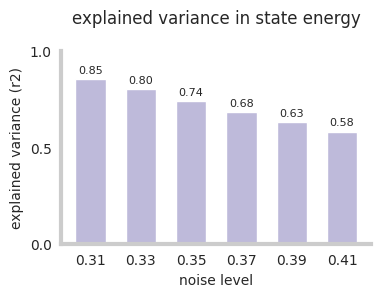

In [193]:
from matplotlib.cm import get_cmap

cmap = plt.colormaps['Set3']

fig, ax = plt.subplots()

xticks = [str(i) for i in hopfield_embeddings_all.keys()]

ax.bar(xticks, expl_var, color=cmap(2), width=0.6)

# Add data labels
for x, y in zip(xticks, expl_var):
    ax.text(x, y + 0.03, f'{y:.2f}', ha='center', fontsize=8)

ax.set_ylabel('explained variance (r2)')
ax.set_xlabel('noise level')
ax.set_title('explained variance in state energy', pad=20)

ax.set_yticks([0, 0.5, 1])
ax.set_ylim([0, 1])

ax.grid(False)

ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

# 2: cross-validated classification accuracy of state basins in first two PCs 

In [10]:
from joblib import Parallel, delayed

def get_attractors_per_timesample(timeseries, hopnet, threshold=0):
    def workhorse(ts_i):
        activity = timeseries[ts_i]
        fit = hopnet.update(activity, threshold=threshold, beta=hopnet.beta)
        attractor_state = np.array(fit[0])
        return attractor_state

    attractor_states = Parallel(n_jobs=-1)(delayed(workhorse)(i) for i in range(len(timeseries)))
    return attractor_states


def label_att_states(attractor_states, statedict, rtol=1e-05, atol=1e-08):
    ts_statelabels = np.zeros(len(attractor_states), dtype=int)
    for ts_i, attractor_state in enumerate(attractor_states):
        # store attractor state labels
        label = -1
        for dict_i, dictval in enumerate(statedict):
            if np.all(np.isclose(attractor_state, dictval, rtol=rtol,
                                 atol=atol)):  # or np.all(np.isclose(-1*attractor_state, dictval)):
                label = dict_i
                break
        if label < 0:
            statedict.append(attractor_state)
            label = len(statedict) - 1
        ts_statelabels[ts_i] = label
    return ts_statelabels, statedict


In [31]:
# use the state sample and do a normal hopfield relaxation to get the true attractor labels
statedict = []
hopnet.beta = 0.04
attractor_states = get_attractors_per_timesample(hopfield_embedding.state_sample, hopnet)
attractor_labels, statedict = label_att_states(attractor_states, statedict)

In [171]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

n_dim = 2 

model = LogisticRegression(multi_class="multinomial")

embedded_states = hopfield_embedding.embedding_model.transform(hopfield_embedding.state_sample)

scores = cross_val_score(model, embedded_states[:,:n_dim], attractor_labels, cv=10)

print(f'mean {np.round(np.mean(scores), decimals=3)} +/- {np.round(np.std(scores), decimals=3)}')
print(scores)


mean 0.964 +/- 0.017
[0.93 0.98 0.96 0.99 0.96 0.95 0.96 0.96 0.99 0.96]


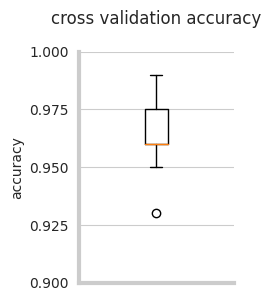

In [196]:
import matplotlib.pyplot as plt
import numpy as np

cmap = plt.colormaps['Set3']

fig, ax = plt.subplots(figsize=[2,3])

ax.boxplot(scores, showfliers=True)  # Set showfliers to False to hide outliers
ax.set_ylabel("accuracy")
ax.set_title("cross validation accuracy", pad=20)

#x = np.random.normal(1, 0.04, size=len(scores))
#plt.plot(x, scores, 'r.', alpha=0.7)

ax.set_yticks([0.9, 0.925, 0.95, 0.975, 1])
ax.set_ylim([0.9, 1])
ax.set_xticks([])
ax.grid(True)

ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()


# 3: null model for frac. occupancy: phase randomization of activity maps

# 4: induced non-linear dynamics through induced linear shift

# 5: Table with full clinical results

In [212]:
import pandas as pd

clinical_results = pd.read_csv('../data_in/full_results_clinical.csv', index_col=0)

In [214]:
# some formatting
clinical_results['eff_size'] = clinical_results['eff_size'].round(decimals=3)
clinical_results['p_val'] = clinical_results['p_val'].round(decimals=5)
clinical_results['p_val'] = clinical_results['p_val'].astype(str)
clinical_results['p_val'] = clinical_results['p_val'].replace('0.0', '<0.0001')

# replace att states with real names
att_names = {0: 'execution', 1: 'internal', 2: 'external', 3:'perception'}
clinical_results['state'] = clinical_results['state'].replace(att_names)

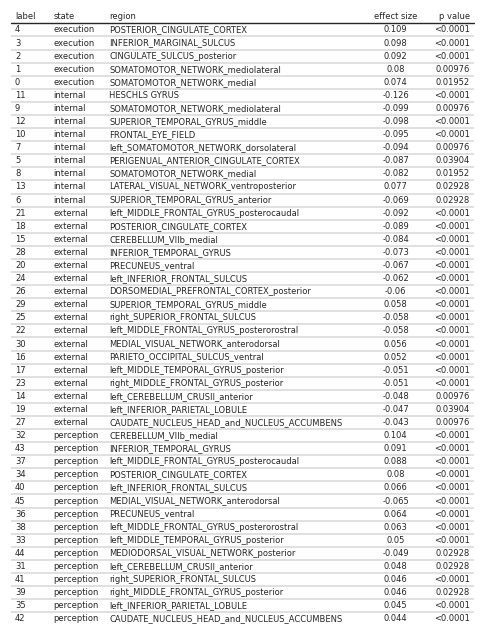

In [218]:
from plottable import Table, ColDef

table_col_defs = [
    ColDef("index", width=1, title="label", textprops={"ha": "left"}),
    ColDef("state", width=0.8, title="state", textprops={"ha": "left"}),
    ColDef("region", width=7, title="region", textprops={"ha": "left"}),
    ColDef("eff_size", width=2, title="effect size", textprops={"ha": "center"}),
    ColDef("p_val", width=1, title="p value", textprops={"ha": "right"})
]

fig, ax = plt.subplots(figsize=(6, 8))
tab = Table(clinical_results,
           column_definitions=table_col_defs,
           textprops={"fontsize": 6, "ha": "center"})

plt.savefig('../data_out/fig/supplement/clinical_results_table.pdf')
glue("clinical_results_table", fig, display=False)
plt.show()

# 6: The hyperparameters of the FCHN

### How do attractor states emerge across beta and the threshold parameter?

In [84]:
def beta_sweep(hopnet, random_num_iter, hopfield_num_iter, beta_iter=np.linspace(0, 0.2, 200),
               n_jobs=-1):
    result = Parallel(n_jobs=n_jobs, verbose=0)(
        delayed(beta_sweep_workhorse)(beta, hopnet, random_num_iter, hopfield_num_iter)
        for beta in beta_iter)

    n_attractors, conv_failure, max_it, med_it, std_it, beta = zip(*result)

    df = pd.DataFrame(columns=['beta', 'threshold', 'num_attractors', 'conv_failure', 'max_it', 'med_it', 'sd_it'])

    for i in range(len(max_it)):
        df = pd.concat([df, pd.DataFrame([{'num_attractors': n_attractors[i],
                        'conv_failure': conv_failure[i],
                        'max_it': max_it[i],
                        'med_it': med_it[i],
                        'sd_it': std_it[i],
                        'beta': beta[i],
                        'threshold': hopnet.threshold}])],
                       ignore_index=True)
    return df


def beta_sweep_workhorse(beta, hopnet, random_num_iter=100, hopfield_num_iter=10000):
    hopnet.beta = beta
    iters = np.zeros(random_num_iter)
    att_states = np.zeros(shape=(random_num_iter, hopnet.num_neuron))


    random_act = np.zeros(shape=(random_num_iter, hopnet.num_neuron))

    sparsity = 10
    base_state = np.concatenate((np.repeat(0.1, sparsity),
                                np.repeat(0, hopnet.num_neuron - sparsity)),
                                axis=0)

    for i in range(random_num_iter):
        random_act[i, :] = network.fun_random_shuffle(base_state)
        att_states[i, :], iters[i] = hopnet.update(random_act[i, :], num_iter=hopfield_num_iter)[:2]

    unique, counts = network.count_unique_states(att_states)
    conv_failure = (iters >= hopfield_num_iter).sum() / random_num_iter * 100

    return len(unique), conv_failure, np.max(iters), np.median(iters), np.std(iters), beta

In [85]:
scale = True

for idx, threshold in enumerate(range(11)):
    hopnet = network.Hopfield(mtx.values,
                              scale=scale,
                              threshold=threshold)
    df = beta_sweep(hopnet=hopnet,
                             random_num_iter=100,
                             hopfield_num_iter=10000,
                             beta_iter=np.linspace(0, 0.08, 41))
    if idx == 0:
        df_pooled = df.copy()
    else :
        df_pooled = pd.concat([df_pooled, df], ignore_index=True)

/tmp/ipykernel_854804/721474869.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm', max(df_pooled.num_attractors))


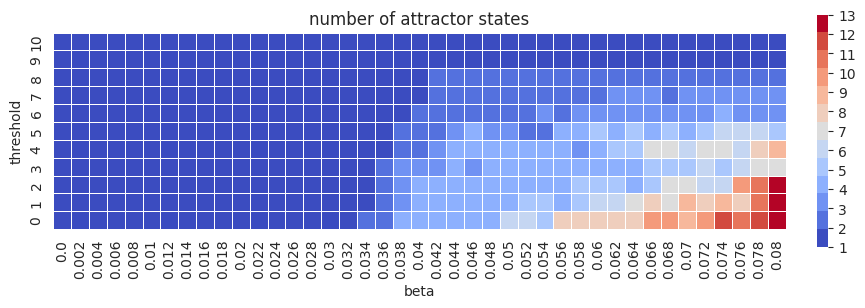

In [87]:
import matplotlib.cm as cm 

plt.rcParams["figure.figsize"] = (10, 4)

for i in range(11):
    idx = 41*i
    if i == 0:
        arr = df_pooled['num_attractors'].values[idx:idx+41]
    else:
        arr=np.vstack((arr, df_pooled['num_attractors'].values[idx:idx+41]))
        
cmap = cm.get_cmap('coolwarm', max(df_pooled.num_attractors))  
ticks = np.linspace(1, max(df_pooled.num_attractors), max(df_pooled.num_attractors), endpoint=True)

xticks = np.round(np.linspace(0, 0.08, 41), 3)
yticks = range(10,-1,-1)
sns.heatmap(np.flipud(arr.astype(float)), 
            cmap=cmap, 
            xticklabels=xticks, 
            yticklabels=yticks, 
            square=True,
           linewidths=0.5,
           cbar_kws={"ticks":ticks, "fraction":0.015, "pad":0.04})

plt.xlabel('beta')
plt.ylabel('threshold')
plt.title('number of attractor states')

plt.savefig('../data_out/fig/supplement/att_state_emergence_over_beta.pdf')
plt.show()

### How robust is the emergence of the attractor states, when adding an increasing amount of noise to the connectome?

We get two reference states from the connectome and iteratively add noise to the connectome. To account for the change in dynamics, we adjust the temperature of the noisy FCHN so that exactly two states emerge. We then highlight the decrease in nodal strength of the noisy connectome (the FCHN weights) vs the correlation of the attractor states that emerge from the noisy connectome.

In [88]:
from connattractor.network import get_n_attractor_states, map_out_attractors
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 

def correlate_states(state_set):
    state_ref = state_set[0]
    state_corr = []
    
    for states in state_set[1:]:
        temp = []
        for state in states:
            for ref in state_ref:
                temp.append(np.corrcoef(state, ref)[0, 1])
        state_corr.append(temp)        
    return state_corr


def find_matching_attractor_states(hopfield_net,
                                   reference_state,
                                   corr_thresh=0.7,
                                   beta_start=0):
    
    beta_lin = np.linspace(beta_start, 0.1, 20)
    
    default_result = (None, None, None)
    
    for beta in beta_lin:
        # calc states for beta
        hopfield_net.beta = beta
        n_states, attractors, counts, iters = map_out_attractors(hopfield_net)
        
        # break after too many states
        #if n_states > 20:
        #    print('more than 20 states')
        #    return default_result
        
        state_corr = []
        for state in attractors:
            state_corr.append(np.corrcoef(state, reference_state)[0, 1])     
        
        if np.max(state_corr) >= corr_thresh:
            r = np.max(state_corr)
            #print(f'found matching state with r={r:.3f}')
            return attractors[np.argmax(state_corr)], r, beta
    print('no matching state found')
    return default_result

def robustness_analysis(hopnet, noise_lin, plot_states=False):
    state_corr = []
    nodal_str_ref = np.sum(hopnet.W, axis=1)
    nodal_str_corr = []
    matching_states = []

    np.random.seed(289)
    # get the reference state from the first state pair 
    states, beta = get_n_attractor_states(hopnet, n_target_states=2, verbose=False)[:2]
    ref_state = network.delete_inverse_states(states)[0]

    scaled_weights = hopnet.W
    nodal_str_ref = np.sum(scaled_weights, axis=1)
    hopnet.beta = beta
    
    for noise_std in tqdm(noise_lin):

        M_noise = np.tril(scaled_weights, -1)
        noise = np.tril(np.random.normal(0, noise_std, np.shape(M_noise)), -1)
        M_noise = M_noise + noise
        M_noise = M_noise + np.swapaxes(M_noise,0,1)

        hopnet_noise = network.Hopfield(M_noise, scale=False)
        hopnet_noise.beta = beta

        matching_state, r, beta = find_matching_attractor_states(hopnet_noise, ref_state, beta_start=hopnet.beta)
        
        if plot_states and  matching_state is not None:
            print(f'added noise with {noise_std:.2f} std')
            network.State(matching_state).plot()
            plt.show()

        matching_states.append(matching_state)
        nodal_str_corr.append(np.corrcoef(nodal_str_ref, np.sum(M_noise, axis=1))[0, 1])
        state_corr.append(r)

    return matching_states, state_corr, nodal_str_corr

In [89]:
noise_lin = np.linspace(0, 1, 51)
hopnet = network.Hopfield(mtx.values, scale=True)
matching_states, state_corr, nodal_str_corr = robustness_analysis(hopnet, noise_lin, plot_states=False)

  0%|          | 0/51 [00:00<?, ?it/s]

no matching state found


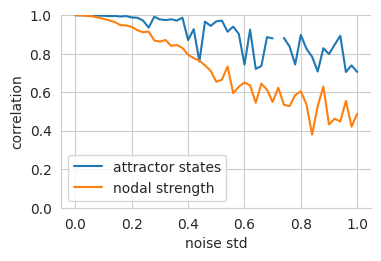

In [90]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [4, 2.5]

ax = plt.subplot(111)

ax.plot(noise_lin, state_corr)
ax.plot(noise_lin, nodal_str_corr)
ax.legend(['attractor states', 'nodal strength'])
plt.xlabel('noise std')
plt.ylabel('correlation')
plt.ylim([0,1])
ax.spines[['right', 'top']].set_visible(False)

plt.savefig('../data_out/fig/supplement/noise_robustness_weights.pdf')
plt.show()

# Fractional occupancy across state configurations (simulation)

In [271]:
simresults = {}
hopfield_embeddings = {}

for beta, noise in [(0.035,0.2), (0.04,0.37), (0.05, 0.65)]:
    simresults[beta] = analysis.simulate_activations(mtx.values, 
                                           noise_coef=noise, 
                                           num_iter=100000, 
                                           beta=beta, 
                                           random_state=2023)
    hopfield_embeddings[beta] = analysis.create_embeddings(simresults[beta], 
                                                 attractor_sample=1000,
                                                 random_state=2023)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.44it/s]


Power_divergenceResult(statistic=4.356, pvalue=0.03687880184110112)
[46.7 53.3]


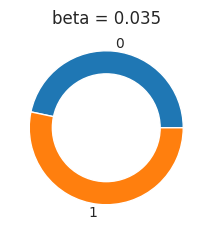

Power_divergenceResult(statistic=341.00800000000004, pvalue=1.3202130113517053e-73)
[10.5 41.9 37.1 10.5]


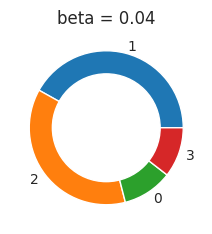

Power_divergenceResult(statistic=488.28800000000007, pvalue=2.692194415786733e-103)
[16.4 30.7 17.8 30.7  2.3  2.1]


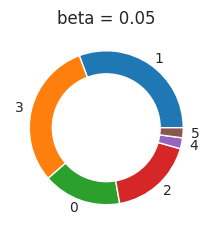

In [287]:
from scipy.stats import chisquare
att_order = {
    0.035: [0, 1],
    0.04: [1,2,0,3],
    0.05: [1,3,0,2,4,5]
}

for beta, embedding in hopfield_embeddings.items():
    sim_attractor_states = embedding.attractor_sample
    label, counts = np.unique(sim_attractor_states, return_counts=True)
    
    plt.pie(counts[att_order[beta]], labels = label[att_order[beta]])

    my_circle=plt.Circle( (0,0), 0.7, color='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.title(f'beta = {beta}')
    print(chisquare(counts))
    print(counts / np.sum(counts) * 100)
    plt.show()